In [1]:
code_dir = "../UXO_protected/+BTInvertPY"

In [2]:
import numpy as np
import os
import h5py
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import cm as cmap
from matplotlib import colors
from matplotlib.colors import Normalize
from mpl_toolkits import mplot3d

import uxo_utils
from uxo_utils import (
    SensorInfo, Model, preCalcLoopCorners, FModParam, 
    forwardWithQ, sensorCoords2RxCoords, hprimary, formQmatrix
)

In [3]:
from matplotlib import rcParams
rcParams['font.size'] = 14
np.random.seed(2020)

## load sensor info and ordnance data

In [4]:
sensorinfo = uxo_utils.load_sensor_info()
ordnance = uxo_utils.load_ordnance_dict()

In [5]:
ordnance.keys()

dict_keys(['105mm', '2.36-in', '2.75-in', '2.95-in', '20-lb Bomb', '25-lb Bomb', '3-in', '3.5-in', '30mm', '37mm', '4-in', '4-in Sphere', '4.2-in', '4.5-in', '4.52-in', '5-lb Bomb', '57mm', '60mm', '66mm', '75mm', '76mm', '81mm', '90mm', '106mm', 'ISO Large', 'ISO Medium', 'ISO Small', '2.25-in'])

## set up survey parameters
- x is cross-line
- y is inline

In [6]:
ntx = len(sensorinfo.transmitters)
ymax = 3. 
y_spacing = 0.2
dy = y_spacing / ntx
nloc = int(ymax/dy)
ncycles = int(nloc/ntx)

y = np.linspace(0, ymax-dy, nloc)
x = np.zeros(nloc)
z = 0.28 * np.ones(nloc)

pitch = np.zeros(nloc)
roll = np.zeros(nloc)
yaw = np.zeros(nloc)  # moving north (sensor in typical orientation)

txnum = np.kron(np.ones(ncycles), np.arange(ntx))

In [7]:
# Convert sensor location coordinates to Rx locations
pos, mnum = sensorCoords2RxCoords(
    sensorinfo=sensorinfo,
    x = x, 
    y = y, 
    z = z, 
    pitch = pitch, 
    roll = roll, 
    yaw = yaw,
    txnum = txnum
)

pitch = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(pitch)])
roll = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(roll)])
yaw = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(yaw)])
pos = np.concatenate(pos,axis=0)

In [8]:
for i in range(3):
    print(pos[:, i].min(), pos[:, i].max())

-1.0 1.0
-0.25 3.21
0.28 0.28


In [9]:
nloc

75

# ordnance objects

In [10]:
times = ordnance["ISO Small"]["times"]

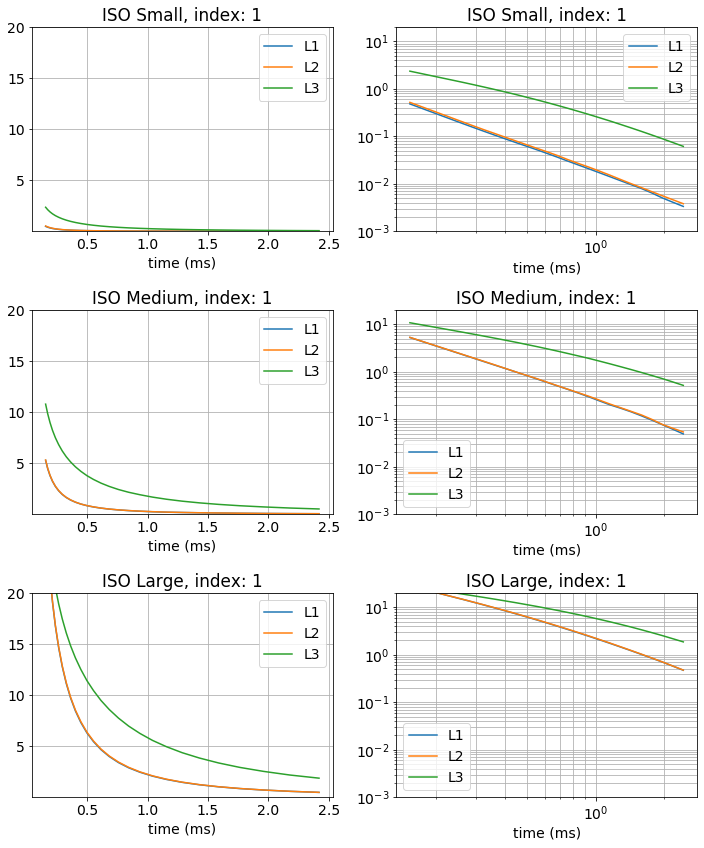

In [11]:
plot_me = {
    "ISO Small": 1,
    "ISO Medium": 1,
    "ISO Large": 1,
}
fig, ax = plt.subplots(len(plot_me.keys()), 2, figsize=(10, 4*len(plot_me.keys())))

for i, key in enumerate(plot_me.keys()):
    for l in ["L1", "L2", "L3"]:
        L = ordnance[key][l][plot_me[key]]
        ax[i, 0].plot(times, L, label=l)
        ax[i, 1].loglog(times, L, label=l)

    for a in ax[i, :]:
        a.set_title(f"{key}, index: {1}")
        a.grid(which="both")
        a.legend()
        a.set_xlabel("time (ms)")
        a.set_ylim([1e-3, 20])
        
plt.tight_layout()

# ranges of parameters

In [12]:
depth_ranges = [
    np.r_[0, 0.5], 
    np.r_[0, 0.5],
    np.r_[0, 0.5],
]

x_range = np.r_[-1.25, 1.25]
y_range = np.r_[0., ymax]

yaw_range = np.r_[0, 2*np.pi]
pitch_range = np.r_[0, 2*np.pi]
roll_range = np.r_[0, 2*np.pi]

noise_amplitudes = np.r_[0, 0.]

def generate_random_variables(n, bounds):
    return bounds.min() + (bounds.max() - bounds.min()) * np.random.rand(n)

In [13]:
ntrain = 2048*2 #*4
ntest = 1024
nvalid = 1024

class_dict = {
    0: "not TOI",
    1: "ISO Small",
    2: "ISO Medium", 
    3: "ISO Large",
}
n_class = len(class_dict.keys())

In [14]:
labels_train = np.random.choice(n_class, ntrain)
labels_test = np.random.choice(n_class, ntest)
labels_valid = np.random.choice(n_class, nvalid)

def generate_parameters(labels):
    n = len(labels)
    
    depths = np.zeros(n)
    
    x = generate_random_variables(n, x_range)
    y = generate_random_variables(n, y_range)

    yaw = generate_random_variables(n, yaw_range)
    pitch = generate_random_variables(n, pitch_range)
    roll = generate_random_variables(n, roll_range)
    
    noise_amplitude = generate_random_variables(n, noise_amplitudes)
    
    polarizations = np.zeros(n, dtype=int)
        
    for i in np.unique(labels):
        ii = labels == i
        if class_dict[i] != "not TOI":
            depths[ii] = generate_random_variables(ii.sum(), depth_ranges[i-1])
            polarizations[ii] = np.random.choice(len(ordnance[class_dict[i]]["L3"]), ii.sum())
    
    return pd.DataFrame({
        "label": labels,
        "depth": depths,
        "x": x,
        "y": y,
        "z": -depths,
        "yaw": yaw,
        "pitch": pitch,
        "roll": roll, 
        "noise_amplitude": noise_amplitude,
        "polarizations": polarizations,
    })

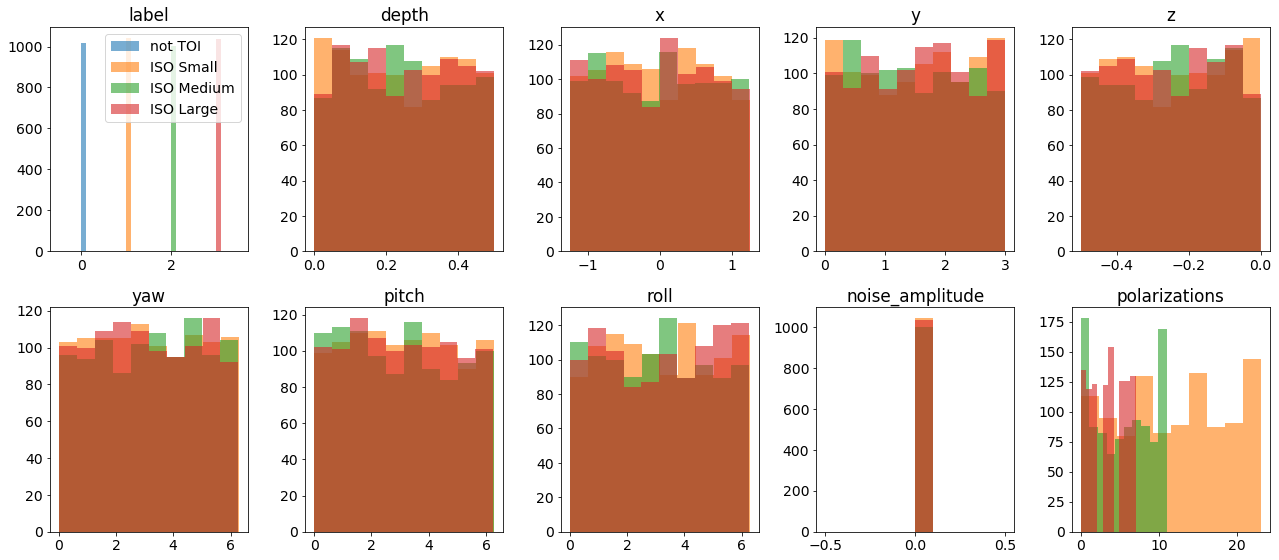

In [15]:
params_train = generate_parameters(labels_train) 
params_test = generate_parameters(labels_test) 
params_valid = generate_parameters(labels_valid) 

fig, ax = plt.subplots(2, 5, figsize=(18, 8))
ax = ax.flatten()

i = 0
for key, val in params_train.items():
    for j in range(n_class):
        if key != "label" and j ==0: 
            pass  # these parameters are irrelevant if there is no object
        else:
            inds = labels_train == j
            ax[i].hist(val[inds], 10, color=f"C{j}", alpha=0.6)
    ax[i].set_title(key)
    i += 1

ax[0].legend(list(class_dict.values()))
plt.tight_layout()

# set up forward simulations

In [16]:
def noise_model(times, amplitude=0.1, slope=-1, intercept=-0.5):
    return amplitude * np.exp(slope * np.log(times) + intercept)

In [17]:
# figuring out where all of the vertices are in coordinate system -- gives us location of vertices 
Tx_indices_rot, Rx_indices_rot = preCalcLoopCorners(
    sensorinfo=sensorinfo, mnum=mnum, rlist=pos, pitch=pitch, roll=roll, yaw=yaw
) 

# convienence object for inputs to fwd modelling 
st = FModParam(sensorinfo, pos, mnum, times, Tx_indices_rot, Rx_indices_rot)  

In [18]:
def run_simulations(parameters, st=st, mnum=mnum, ncycles=ncycles):
    data = []
    noise = []
    for i, l in enumerate(parameters["label"]):
        if l == 0:
            # this can later be replaced with random noise or other structured but uninteresting signal
            V = np.zeros((pos.shape[0], len(times)))
        else: 
            xyz = np.r_[parameters["x"][i], parameters["y"][i], parameters["z"][i]]
            ypr = np.r_[parameters["yaw"][i], parameters["pitch"][i], parameters["roll"][i]]
            pi = parameters["polarizations"][i]
            L3 = ordnance[class_dict[l]]["L3"][pi]
            L2 = ordnance[class_dict[l]]["L2"][pi]
            L1 = ordnance[class_dict[l]]["L1"][pi]
            
            mod = Model(xyz=xyz, gba=ypr, l3=L3, l2=L2, l1=L1, times=times)
            V = forwardWithQ(mod, st) # nT/s (some version of db/dt)
        V = V.reshape(ncycles, mnum.max()+1, len(times))
        V = np.swapaxes(V, 0, 1)
        data.append(V)
        noise.append(
            np.random.randn(np.prod(V.shape)).reshape(V.shape) * 
            noise_model(times, amplitude=parameters["noise_amplitude"][i])
        )
    return data, noise
    
    

In [19]:
%%time
data_clean_train, noise_train = run_simulations(params_train)
data_train = [d + n for d, n in zip(data_clean_train, noise_train)]

CPU times: user 1min 1s, sys: 2.62 s, total: 1min 3s
Wall time: 17.5 s


In [20]:
%%time
data_clean_test, noise_test = run_simulations(params_test)
data_clean_valid, noise_valid = run_simulations(params_valid)

data_test = [d + n for d, n in zip(data_clean_test, noise_test)]
data_valid = [d + n for d, n in zip(data_clean_valid, noise_valid)]

CPU times: user 33.3 s, sys: 1.77 s, total: 35.1 s
Wall time: 10 s


In [21]:
time_scaling = (times)
time_scaling

array([0.154, 0.171, 0.19 , 0.211, 0.235, 0.262, 0.292, 0.325, 0.361,
       0.401, 0.446, 0.496, 0.551, 0.613, 0.681, 0.758, 0.842, 0.936,
       1.04 , 1.156, 1.286, 1.429, 1.588, 1.764, 1.961, 2.178, 2.42 ])

In [22]:
scaled_data_train = [d*time_scaling for d in data_train]
scaled_data_test = [d*time_scaling for d in data_test]
scaled_data_valid = [d*time_scaling for d in data_valid]


## plot some sample data

In [23]:
pos = np.swapaxes(pos.reshape(ncycles, mnum.max()+1, 3), 0, 1)

In [24]:
dind = 6
d = data_train[dind]

print(f"class: {class_dict[labels_train[dind]]}, data shape: {d.shape}")

params_train.iloc[dind]

class: ISO Small, data shape: (165, 15, 27)


label              1.000000
depth              0.186398
x                 -0.005348
y                  1.011331
z                 -0.186398
yaw                4.536784
pitch              0.046701
roll               1.515021
noise_amplitude    0.000000
polarizations      6.000000
Name: 6, dtype: float64

In [25]:
# tx_num, rx_num, rx_comp, rxcube
sensor_table = sensorinfo.measNum2TxRxRxcCube()

In [26]:
len(sensor_table)

165

Text(0.5, 0.92, 'Transmitter 2, Target 6: ISO Small')

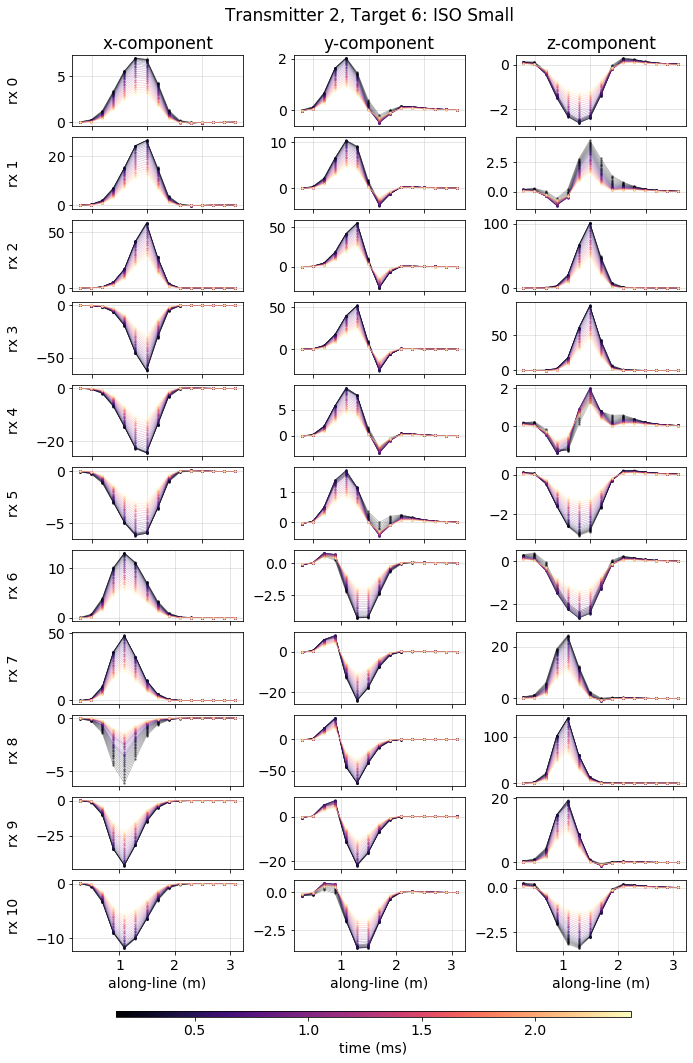

In [27]:
nrx = 11
fig, ax = plt.subplots(nrx, 3, figsize=(11, 1.5*nrx))
fig.subplots_adjust(wspace=0.3, hspace=0.15)

plot_tx = 1
tx_inds = (sensor_table[:, 0] == plot_tx)

cm = plt.get_cmap('magma')
c_norm = Normalize(vmin=times.min(), vmax=times.max())
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

d = scaled_data_train[dind]

for rx in range(nrx):
    ii = tx_inds & (sensor_table[:, 3] == rx)
    for a, comp in zip(ax[rx, :], [0, 1, 2]):
        mnumind = np.where( ii & (sensor_table[:, 2] == comp))[0][0]
        for t in range(len(times)):
            a.plot(
                pos[mnumind, :, 1], d[mnumind, :, t], 
                color=scalar_map.to_rgba(times[t]), marker=".", lw=0.5, alpha=0.4, ms=3
            )

        a.grid(which="both", alpha=0.4)
        if rx < nrx-1:
            a.set_xticklabels('')
        else:
            a.set_xlabel("along-line (m)")
        
        if rx == 0:
            if comp == 0:
                a.set_title("x-component")
            elif comp == 1:
                a.set_title("y-component")
            elif comp == 2:
                a.set_title("z-component")
        
        if comp == 0:
            a.set_ylabel(f"rx {rx}")
            a.yaxis.set_label_coords(-0.3, 0.5)
            
# plt.tight_layout()
cbar_ax = fig.add_axes([0.18, 0.07, 0.65, 0.005])
cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
cb.set_label('time (ms)')

fig.suptitle(f"Transmitter {plot_tx+1}, Target {dind}: {class_dict[labels_train[dind]]}", y=0.92)


Text(0.5, 0.92, 'Transmitter 1, Target 6: ISO Small')

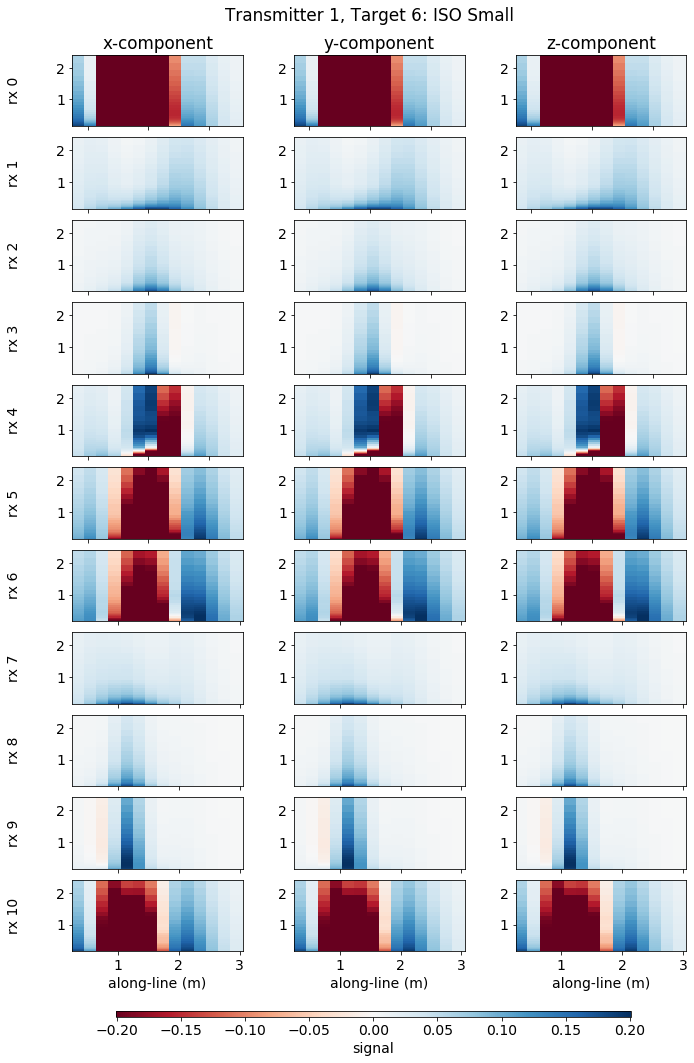

In [28]:
nrx = 11
fig, ax = plt.subplots(nrx, 3, figsize=(11, 1.5*nrx))
fig.subplots_adjust(wspace=0.3, hspace=0.15)

plot_tx = 0
tx_inds = (sensor_table[:, 0] == plot_tx)

d = scaled_data_train[dind]

for rx in range(nrx):
    ii = tx_inds & (sensor_table[:, 3] == rx)
    plotme = d[mnumind, :, :].T
    for a, comp in zip(ax[rx, :], [0, 1, 2]):
        mnumind = np.where( ii & (sensor_table[:, 2] == comp))[0][0]
        out = a.pcolormesh(
            pos[mnumind, :, 1], times, 
            plotme, cmap="RdBu", vmin=-(np.abs(plotme.max())).max(), vmax=(np.abs(plotme.max())).max()
        )

#         a.grid(which="both", alpha=0.4)
#         a.set_aspect(1)
        if rx < nrx-1:
            a.set_xticklabels('')
        else:
            a.set_xlabel("along-line (m)")
        
        if rx == 0:
            if comp == 0:
                a.set_title("x-component")
            elif comp == 1:
                a.set_title("y-component")
            elif comp == 2:
                a.set_title("z-component")
        
        if comp == 0:
            a.set_ylabel(f"rx {rx}")
            a.yaxis.set_label_coords(-0.3, 0.5)

cbar_ax = fig.add_axes([0.18, 0.07, 0.65, 0.005])
cb = plt.colorbar(out, cbar_ax, orientation="horizontal")
cb.set_label('signal')

fig.suptitle(f"Transmitter {plot_tx+1}, Target {dind}: {class_dict[labels_train[dind]]}", y=0.92)


# build a ConvNet classifier 

In [29]:
import torch
from torch import nn
from torch.nn import functional

In [30]:
use_scaled = True
# normalize_unit = True

if use_scaled is True: 
    X_train = torch.from_numpy(np.float32(np.stack(scaled_data_train, axis=0)))
    X_test = torch.from_numpy(np.float32(np.stack(scaled_data_test, axis=0)))
    X_valid = torch.from_numpy(np.float32(np.stack(scaled_data_valid, axis=0)))

elif use_scaled is False: 
    X_train = torch.from_numpy(np.float32(np.stack(data_train, axis=0)))
    X_test = torch.from_numpy(np.float32(np.stack(data_test, axis=0)))
    X_valid = torch.from_numpy(np.float32(np.stack(data_valid, axis=0)))

# if normalize_unit it True:
    


C_train = torch.from_numpy(np.float32(labels_train)).long()
C_test = torch.from_numpy(np.float32(labels_test)).long()
C_valid = torch.from_numpy(np.float32(labels_valid)).long()

In [31]:
class ConvNet(nn.Module):
    
    def __init__(self, network_geometry):
        super().__init__()
        self.network_geometry=network_geometry
        self.nt = len(network_geometry)
        self.batch_norm = nn.BatchNorm2d(network_geometry[0])
    
    def forward(self, X, K, batch_norm): 
#         X = self.batch_norm(X)
        for i, Ki, bn in zip(range(self.nt), K, batch_norm):
            z = functional.conv2d(X, Ki, stride=1) #, padding=1)
            z = bn(z)
            z = functional.relu(z)
#             z = functional.max_pool2d(z, 3, stride=1) #, padding=1)
            X = z
        return X

In [32]:
in_channels = 165
# n_class = 4
layer_geometries = [in_channels, 33, 11, 11] #11, 11, 11]
nlayers = len(layer_geometries)
initial_scaling = 1e-3

width = nloc//ntx
ntimes = len(times)

# initialize K's and batch normalizations
K = []
batch_norm = []
bias = []
for i in range(nlayers-1):
    n_in = layer_geometries[i]
    n_out = layer_geometries[i+1]
    Ki = nn.Parameter(torch.Tensor(n_out, n_in, 3, 3))
    Ki.data = torch.randn(n_out, n_in, 3, 3)  * initial_scaling
    K.append(Ki)
    
    batch_norm.append(nn.BatchNorm2d(n_out))

# initialize classifier W
coarsening = (len(layer_geometries)  - 1)*2
W = nn.Parameter(torch.Tensor(layer_geometries[-1]*(width-coarsening)*(ntimes-coarsening), n_class))
W.data = torch.randn(layer_geometries[-1]*(width-coarsening)*(ntimes-coarsening), n_class)*initial_scaling

b = nn.Parameter(torch.randn(n_class)*initial_scaling, requires_grad=True)

In [33]:
net = ConvNet(layer_geometries)

In [34]:
# run the network

with torch.no_grad():
    out = net(X_train, K, batch_norm)

In [35]:
loss_func = nn.CrossEntropyLoss()

def misfit(X, W, b, C):
    n = W.shape
    X = X.view(-1, n[0])
    S = torch.matmul(X, W) + b.unsqueeze(0)

    probs = functional.softmax(S, dim=1)
    return loss_func(S, C), probs

In [36]:
n_parout = (
    np.sum(np.array([np.prod(Ki.shape) for Ki in K])) + np.prod(W.shape)
)

print('Total number of parameters', n_parout)
print('Total number of data', labels_train.shape[0])

Total number of parameters 61677
Total number of data 4096


In [37]:
def accuracy(S, labels):
    _, predicted = torch.max(S, dim=1)
    total = np.prod(labels.size())
    correct = (predicted == labels).sum().item()
    return correct/total

In [38]:
loss, probs = misfit(out, W, b, C_train)
print('Initial loss = ', loss.detach().numpy())    
print(f'Check:log({n_class}) = ', np.log(n_class))

print(f"\nInitial accuracy: {accuracy(probs, C_train)}")
print(f"Check random    : {1/n_class}")

Initial loss =  1.3839175
Check:log(4) =  1.3862943611198906

Initial accuracy: 0.30615234375
Check random    : 0.25


In [39]:
batch_size = 32

In [40]:
import torch.optim as optim
optimizer = optim.SGD(
    [{'params': W}, {'params':b}, {'params': K}], 
    lr = 1e0, momentum=0
)


In [41]:
running_loss_train = []
running_loss_test = []
running_accuracy_train = []
running_accuracy_test = []

In [ ]:
for epoch in range(15):  # loop over the dataset multiple times

    # zero the parameter gradients
    g = 0.0
    loss = 0.0
    ind = 0
    
    while ind < X_train.shape[0]:    
        optimizer.zero_grad()
        # get the inputs
        inputs = X_train[ind:ind+batch_size, :, :, :]
        labels = C_train[ind:ind+batch_size]

        # forward 
        x = net(inputs, K, batch_norm)
        lossi, _ = misfit(x, W, b, labels)
        if i==0:
            loss = lossi
        else:
            loss += lossi
        lossi.backward()
        optimizer.step()
        ind += batch_size
        
    with torch.no_grad():
        xtest = net(X_test, K, batch_norm)
        loss_test, probs_test = misfit(xtest, W, b, C_test)

        xtrain = net(X_train, K, batch_norm)
        loss_train, probs_train = misfit(xtrain, W, b, C_train)

        accuracy_train = accuracy(probs_train, C_train)
        accuracy_test = accuracy(probs_test, C_test)

        g = torch.norm(W.grad) + sum([torch.norm(Ki.grad) for Ki in K]) + torch.norm(b.grad)

        running_loss_train.append(loss_train)
        running_loss_test.append(loss_test)
        running_accuracy_train.append(accuracy_train)
        running_accuracy_test.append(accuracy_test)
     
        print(f'{epoch:3d}  {loss:2.3e}  {loss_test:2.3e} {g:2.3e} {accuracy_train:0.3f}  {accuracy_test:0.3f}')

print('Finished Training')

  0  2.331e+03  5.590e+00 1.730e+00 0.432  0.431
  1  1.210e+03  6.010e+00 1.914e+00 0.484  0.472
  2  9.025e+02  3.555e+00 6.321e-01 0.485  0.479
  3  7.382e+02  5.238e+00 1.177e+01 0.762  0.771
  4  4.108e+02  1.157e+00 1.159e+00 0.714  0.751
  5  4.129e+02  1.420e+00 4.365e-01 0.701  0.707
  6  3.109e+02  6.247e-01 9.731e-01 0.749  0.771


In [ ]:
# training set
x_train_net = net(X_train, K, batch_norm)
_, probs_train = misfit(x_train_net, W, b, C_train)
_, pred_train = torch.max(probs_train, dim=1)

# test set
x_test_net = net(X_test, K, batch_norm)
_, probs_test = misfit(x_test_net, W, b, C_test)
_, pred_test = torch.max(probs_test, dim=1)

# validation set
x_valid_net = net(X_valid, K, batch_norm)
_, probs_valid = misfit(x_valid_net, W, b, C_valid)
_, pred_valid = torch.max(probs_valid, dim=1)

In [ ]:
print(f"training accuracy: {accuracy(probs_train, C_train):1.4f}")
print(f"test accuracy    : {accuracy(probs_test, C_test):1.4f}")
print(f"valid accuracy   : {accuracy(probs_valid, C_valid):1.4f}")

In [ ]:
# see where it struggled

def get_mislabeled(S, labels):
    _, predicted = torch.max(S, dim=1)
    incorrect = (predicted != labels)
    return incorrect.numpy()

In [ ]:
mislabeled_train = get_mislabeled(probs_train, C_train)
mislabeled_test = get_mislabeled(probs_test, C_test)
mislabeled_valid = get_mislabeled(probs_valid, C_valid)

_, pred_labels_train = torch.max(probs_train, dim=1)
_, pred_labels_test = torch.max(probs_test, dim=1)
_, pred_labels_valid = torch.max(probs_valid, dim=1)

print(f"Mislabeled. train: {mislabeled_train.sum()}, test: {mislabeled_test.sum()}, valid: {mislabeled_valid.sum()}")

In [ ]:
def confusion_matrix(true_labels, predicted_labels):
    n = len(np.unique(true_labels))
    M = np.zeros((n, n), dtype=int)
    for i in range(n):
        for j in range(n):
            M[i, j] = sum((true_labels == i) & (predicted_labels == j))
    return M

In [ ]:
print(f"rows = True: {class_dict.values()}")
print(f"cols = Pred: {class_dict.values()}")

In [ ]:
confusion_matrix(C_train, pred_labels_train)

In [ ]:
confusion_matrix(C_test, pred_labels_test)

In [ ]:
confusion_matrix(C_valid, pred_labels_valid)

In [ ]:
inds, vals = torch.max(probs_valid[mislabeled_valid, :], dim=0)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(1/len(data_train) * np.array(running_loss_train), label="training")
ax[0].plot(1/len(data_test) * np.array(running_loss_test), label="test")
ax[0].set_title("loss")
ax[0].legend()

ax[1].plot(running_accuracy_train, label="training")
ax[1].plot(running_accuracy_test, label="test")
ax[1].set_title("accuracy")

for a in ax:
    a.grid(which="both")
    a.set_xlabel("epoch")

## look at features in network 

In [ ]:
ind = 6

print(probs_train[ind, :])
print(f"class: {class_dict[labels_train[ind]]}")

params_train.iloc[ind]

In [ ]:
X_train.shape, len(K)

In [ ]:
Z0 = []
Z1 = []
Z2 = []
# Z3 = []
with torch.no_grad():
    X = X_train[ind:ind+1, :, :, :]
    for Ki, bn in zip(K, batch_norm):
        print(Ki.shape)
        z0 = functional.conv2d(X, Ki, stride=1 )#, padding=1)
        z1 = bn(z0)
        z2 = functional.relu(z1)
#         z3 = functional.max_pool2d(z2, 3, stride=1) #, padding=1)
        X = z2
        Z0.append(z0)
        Z1.append(z1)
        Z2.append(z2)
#         Z3.append(z3)

In [ ]:
K[1].shape

In [ ]:
plt.colorbar(plt.pcolormesh(K[1][:, :, 2, 1].data.numpy()))

In [ ]:
fig, ax = plt.subplots(33, 11, figsize = (11*0.5, 33*0.5))

plotme = K[1].detach()
vmax=np.abs(plotme.flatten()).max()
vmin=-vmax
print(vmin, vmax)

for i in range(33):
    for j in range(11):
        a = ax[i, j]
        a.set_xticklabels('')
        a.set_yticklabels('')
        a.pcolormesh(plotme[j, i, :, :], vmin=vmin, vmax=vmax, cmap="RdBu")
# K[1].shape

In [ ]:
Z0[0].shape

In [ ]:
W.shape

In [ ]:
nfeatures = 33
fig, ax = plt.subplots(11, 3, figsize=(11, 1.5*11))
fig.subplots_adjust(wspace=0.3, hspace=0.15)

cm = plt.get_cmap('magma')
c_norm = Normalize(vmin=times.min(), vmax=times.max())
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

plot_me = Z2[0][0, :, :, :]

for i, a in enumerate(ax.flatten()):
    for t in range(plot_me.shape[-1]):
        a.plot(
            plot_me[i, :, t], 
            color=scalar_map.to_rgba(times[t]), marker=".", lw=0.5, alpha=0.4, ms=3
        )

        a.grid(which="both", alpha=0.4)
        if rx < nrx-1:
            a.set_xticklabels('')
            
# plt.tight_layout()
cbar_ax = fig.add_axes([0.18, 0.07, 0.65, 0.005])
cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
cb.set_label('time (ms)')

In [ ]:
nfeatures = 11
fig, ax = plt.subplots(11, 1, figsize=(4, 1.5*11))
fig.subplots_adjust(wspace=0.3, hspace=0.15)

cm = plt.get_cmap('magma')
c_norm = Normalize(vmin=times.min(), vmax=times.max())
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

plot_me = Z2[1][0, :, :, :]

for i, a in enumerate(ax.flatten()):
    for t in range(plot_me.shape[-1]):
        a.plot(
            plot_me[i, :, t], 
            color=scalar_map.to_rgba(times[t]), marker=".", lw=0.5, alpha=0.4, ms=3
        )

        a.grid(which="both", alpha=0.4)
        if rx < nrx-1:
            a.set_xticklabels('')
            
# plt.tight_layout()
cbar_ax = fig.add_axes([0.18, 0.07, 0.65, 0.005])
cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
cb.set_label('time (ms)')

In [ ]:
w_plot = []
with torch.no_grad():
    for i in range(n_class):
        w_plot.append(W[:, i].view(Z2[1].shape).detach())

In [ ]:
nfeatures = 11
fig, ax = plt.subplots(11, len(w_plot), figsize=(4*len(w_plot), 1.5*11))
fig.subplots_adjust(wspace=0.3, hspace=0.15)

cm = plt.get_cmap('magma')
c_norm = Normalize(vmin=times.min(), vmax=times.max())
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

for ii, w in enumerate(w_plot):
    for i, a in enumerate(ax[:, ii]):
        for t in range(w.shape[-1]):
            a.plot(
                w[0, i, :, t], 
                color=scalar_map.to_rgba(times[t]), marker=".", lw=0.5, alpha=0.4, ms=3
            )

            a.grid(which="both", alpha=0.4)
            if rx < nrx-1:
                a.set_xticklabels('')
            
# plt.tight_layout()
cbar_ax = fig.add_axes([0.18, 0.07, 0.65, 0.005])
cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
cb.set_label('time (ms)')

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax = ax.flatten()

for a, probs, title in zip(ax, [probs_train, probs_test, probs_valid], ["train", "test", "valid"]):
    a.set_title(title)
    for i in range(n_class):
        a.hist(probs[:, i].detach().numpy(), 100, color=f"C{i}", alpha=0.6)

# ax[0].legend([class_dict[0], class_dict[1], class_dict[2]])
plt.tight_layout()

# generate a line of data

In [ ]:
ymax_profile = 30
nloc_profile = int(ymax_profile/dy)
ncycles_profile = int(nloc_profile/ntx)

y_profile = np.linspace(0, ymax_profile-dy, nloc_profile)
x_profile = np.zeros(nloc_profile)
z_profile = 0.28 * np.ones(nloc_profile)

pitch_profile = np.zeros(nloc_profile)
roll_profile = np.zeros(nloc_profile)
yaw_profile = np.zeros(nloc_profile)  # moving north (sensor in typical orientation)

txnum_profile = np.kron(np.ones(ncycles_profile), np.arange(ntx))

In [ ]:
# Convert sensor location coordinates to Rx locations
pos_profile, mnum_profile = sensorCoords2RxCoords(
    sensorinfo=sensorinfo,
    x = x_profile, 
    y = y_profile, 
    z = z_profile, 
    pitch = pitch_profile, 
    roll = roll_profile, 
    yaw = yaw_profile,
    txnum = txnum_profile
)

pitch_profile = np.concatenate([np.tile(x,pos_profile[i].shape[0]) for i,x in enumerate(pitch_profile)])
roll_profile = np.concatenate([np.tile(x,pos_profile[i].shape[0]) for i,x in enumerate(roll_profile)])
yaw_profile = np.concatenate([np.tile(x,pos_profile[i].shape[0]) for i,x in enumerate(yaw_profile)])
pos_profile = np.concatenate(pos_profile,axis=0)

In [ ]:
depths_profile = np.r_[0.1] #, 0.25, 0.5, 0.1, 0.4, 0.7]
params_profile = pd.DataFrame({
    "label": [1], #, 1, 1, 1, 1, 1],
    "depth": depths_profile,
    "x": np.r_[0], #, 0, 0, 0, 0, 0],
    "y": np.r_[2], #, 5, 10, 15, 20, 25],
    "z": -depths_profile,
    "yaw": np.r_[0], #, np.pi/4, np.pi, 0, np.pi/4, np.pi/2],
    "pitch": np.r_[0], #, 0, 0, 0, 0, 0],
    "roll": np.r_[0], #, 0, 0, 0, 0, 0],
    "noise_amplitude": np.r_[0], #, 0, 0, 0, 0, 0],
    "polarizations": [0], #, 0, 0, 0, 0, 0]
})
params_profile

In [ ]:
# figuring out where all of the vertices are in coordinate system -- gives us location of vertices 
Tx_indices_rot_profile, Rx_indices_rot_profile = preCalcLoopCorners(
    sensorinfo=sensorinfo, mnum=mnum_profile, rlist=pos_profile, pitch=pitch_profile, roll=roll_profile, yaw=yaw_profile
) 

# convienence object for inputs to fwd modelling 
st_profile = FModParam(sensorinfo, pos_profile, mnum_profile, times, Tx_indices_rot_profile, Rx_indices_rot_profile)  



In [ ]:
data_profile, noise_profile = run_simulations(params_profile, st=st_profile, mnum=mnum_profile, ncycles=ncycles_profile)

In [ ]:
data_profile[0].shape

In [ ]:
X_profile = pos_profile[:, 0].reshape((165, ncycles_profile), order="F")
Y_profile = pos_profile[:, 1].reshape((165, ncycles_profile), order="F")


In [ ]:
D_profile = sum(data_profile)
D_profile.shape

In [ ]:
window_width_profile = int(ymax/y_spacing)
w_step_profile = 5
n_windows_profile = (X_profile.shape[1]-window_width_profile)//w_step_profile
print(n_windows_profile)

In [ ]:
n = D_profile.shape
net_data_profile = np.zeros((n_windows_profile, n[0], window_width_profile, n[2]))
net_y_profile = np.zeros((n_windows_profile, n[0], window_width_profile))
net_x_profile = np.zeros((n_windows_profile, n[0], window_width_profile))

for i in range(n_windows_profile):
    inds = slice(i*w_step_profile,i*w_step_profile+window_width_profile)
    net_x_profile[i, :, :] = X_profile[:, inds]
    net_y_profile[i, :, :] = Y_profile[:, inds]
    net_data_profile[i, :, :, :] = D_profile[:, inds, :]

In [ ]:
if use_scaled is True:
    net_data_profile_torch = torch.from_numpy(np.float32(net_data_profile*time_scaling))
else:
    net_data_profile_torch = torch.from_numpy(np.float32(net_data_profile))

In [ ]:
with torch.no_grad():
    out_field = net(net_data_profile_torch, K, batch_norm)
    n = W.shape
    S = torch.matmul(out_field.view(-1, n[0]), W)
    probs_profile = functional.softmax(S, dim=1)

In [ ]:
_, labels_profile = torch.max(probs_profile, dim=1)

In [ ]:
D_profile[mnum, :, :].shape

In [ ]:
from matplotlib.lines import Line2D

In [ ]:
mnum_plot = 12
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

ordnance_labels = [
    Line2D(
        [0], [0], marker='o', color="w", 
        markerfacecolor=f'C{int(key)}', markeredgecolor=f'C{int(key)}', 
        label=value
    ) for key, value in class_dict.items()
]

ordnance_labels = ordnance_labels + [
    Line2D(
        [0], [0], marker='s', color="w", 
        markerfacecolor=f'C{int(key)}', markeredgecolor=f'C{int(key)}', 
        label=f"true {class_dict[key]}"
    ) for key in [1, 2]
]

ax.plot(Y_profile[mnum_plot, :], D_profile[mnum_plot, :, :], '.', color="k", alpha=0.3)
ax.grid("both", alpha=0.4)

for i in range(net_data_profile.shape[0]):
    y_plot = np.mean(net_y_profile[i, mnum_plot, :])
    ax.plot(y_plot, 0, f'C{labels_profile[i]}o')

txnumplot = sensor_table[mnum_plot, 0]
rxnumplot = sensor_table[mnum_plot, 3]
rxcompplot = sensor_table[mnum_plot, 2]
ax.set_title(f"Transmitter: {txnumplot}, Receiver: {rxnumplot}, {rxcompplot}-component")
ax.set_xlabel("along-line distance (m)")

for i in range(len(depths_profile)):
    label = params_profile["label"][i]
    ax.plot(params_profile["y"][i], -1, f"sC{label}")

ax.legend(handles=ordnance_labels)

# ax.set_xlim([12.5, 17.5])
ax.set_ylim([-2, 8])


In [ ]:
probs_profile

In [ ]:
plt.plot(probs_profile, '.')

# load up a line from the test site

In [ ]:
data_directory = "../UXO_protected/data-blacktusk"
groundtruth = pd.read_excel(os.path.sep.join([data_directory, "groundtruth_Testplot5F.xlsx"]), nrows=93)

In [ ]:
groundtruth = pd.read_excel(os.path.sep.join([data_directory, "groundtruth_Testplot5F.xlsx"]), nrows=93)

In [ ]:
# H5 functions
def proc_attr(inp):
    """HDF5 - Process attributes for the input group and return them in a dictionary."""
    dic = {}
    for att in inp.attrs.keys():
        if inp.attrs[att].dtype.char == 'S':
            dic[att] = [x.strip() for x in inp.attrs[att].tostring().decode('ascii').split(',')]
        else:
            dic[att] = inp.attrs[att][0] if isinstance(inp.attrs[att],np.ndarray) and inp.attrs[att].size==1 else inp.attrs[att]
    return dic
    pass

def proc_group(inp):
    """HDF5 - A recursive function for reading datasets and attributes into a dictionary."""
    dic = {}
    dic.update(proc_attr(inp))
    for key in inp.keys():
        if isinstance(inp[key], h5py.Group):
            dic.update({key:proc_group(inp[key])})
        else:
            dic[key] = inp[key][()]
        pass
    return dic

In [ ]:
dfile = os.path.join(data_directory, 'Testplot5F.h5')
f = h5py.File(dfile, 'r')
dic = proc_group(f)
f.close()

In [ ]:
# Generate the sensorinfo structure
sensor_name = dic['SensorName'][0]
sensor_config = dic['SensorConfig'][0]
afile = os.path.join(code_dir,'config','sensor_definitions','{}___{}.yaml'.format(sensor_name,sensor_config))
sensorinfo = SensorInfo.fromYAML(afile)[0]

print(sensor_name)

In [ ]:
xyz_dict = dic["XYZ"]
ch = xyz_dict['Info']['ChannelNames']
datai = xyz_dict['Info']['Data']['ChannelIndex'].flatten().astype(int)-1 # These are indices to the decay data
yawi = int(xyz_dict['Info']['Yaw']['ChannelIndex'])-1 # index to the yaw channel
mni = int(xyz_dict["Info"]["MeasNum"]["ChannelIndex"])-1
easting = int(xyz_dict["Info"]["Easting"]["ChannelIndex"])-1
northing = int(xyz_dict["Info"]["Northing"]["ChannelIndex"])-1
linesi = int(xyz_dict["Info"]["Line"]["ChannelIndex"])-1
rx_num = int(xyz_dict["Info"]["RxNum"]["ChannelIndex"])-1
tx_num = int(xyz_dict["Info"]["TxNum"]["ChannelIndex"])-1
rx_comp = int(xyz_dict["Info"]["RxCNum"]["ChannelIndex"])-1
rx_num = int(xyz_dict["Info"]["RxNum"]["ChannelIndex"]) - 1

times = np.array(dic['SensorTimes'].flatten())
print(times.min(), times.max(), len(times))

In [ ]:
xyz_data = xyz_dict["Data"]
mn = xyz_data[mni, :].astype(int) - 1

In [ ]:
line_id = 1013 #, 1013]
line_inds = xyz_data[linesi, :] == line_id
print(sum(line_inds))

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(xyz_data[easting, line_inds], xyz_data[northing, line_inds], '.', alpha=0.1, ms=0.2)
ax.plot(groundtruth["Easting"], groundtruth["Northing"], 'k.')

In [ ]:
from scipy import stats

In [ ]:
# local coordinates for the data set 
x0, y0 = np.mean(xyz_data[easting, :]), np.mean(xyz_data[northing, :])
local_easting = xyz_data[easting, :] - x0
local_northing = xyz_data[northing, :] - y0

slope, intercept, _, _, _ = stats.linregress(local_easting, local_northing)
print(slope, intercept)

In [ ]:
theta = np.arctan(slope)+np.pi/2
local_x = np.cos(theta) * local_easting + np.sin(theta) * local_northing
local_y = -np.sin(theta) * local_easting + np.cos(theta) * local_northing


local_ground_truth_easting = np.array(groundtruth["Easting"] - x0)
local_ground_truth_northing = np.array(groundtruth["Northing"] - y0)
local_ground_truth_x = np.cos(theta) * local_ground_truth_easting + np.sin(theta) * local_ground_truth_northing
local_ground_truth_y = -np.sin(theta) * local_ground_truth_easting + np.cos(theta) * local_ground_truth_northing


In [ ]:
line_x = local_x[line_inds]
line_y = local_y[line_inds]

mn_line = mn[line_inds]
fig, ax = plt.subplots(1, 1)
ax.plot(line_x, line_y, '.', ms=0.1)
ax.set_xlim(np.r_[-20, 20])
ax.set_title("rotated coordinate system")

ax.plot(local_ground_truth_x, local_ground_truth_y, 'k.', label="ordnance")

In [ ]:
ord_inds_covered = (
    (local_ground_truth_x >= line_x.min()) & (local_ground_truth_x <= line_x.max()) &
    (local_ground_truth_y >= line_y.min()) & (local_ground_truth_y <= line_y.max())
)

In [ ]:
mn_line = mn[line_inds]
fig, ax = plt.subplots(1, 1, figsize=(8, 14))

for plot_mn in range(11):

    plot_inds = (mn_line==plot_mn)
    ax.plot(line_x[plot_inds], line_y[plot_inds], '.', ms=1, label=plot_mn)

ax.plot(
    local_ground_truth_x[ord_inds_covered], local_ground_truth_y[ord_inds_covered], 'k.', label="ordnance", ms=10
)
lgnd = ax.legend()
[h._legmarker.set_markersize(6) for h in lgnd.legendHandles]

# ax.set_xlim([-12, -2])
ax.set_ylim([-10, 10])
ax.grid("both", alpha = 0.4)
ax.set_aspect(0.5)
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")

In [ ]:
# target data shape 165 X nlocs X nTimes 
# grab by measurement number 
# then re-stack

x_locs = []
y_locs = []
data_list = []
line_data = xyz_data[datai, :][:, line_inds]

for mnind in range(mn.max() + 1):
    mninds = mn_line == mnind
    x_locs.append(line_x[mninds])
    y_locs.append(line_y[mninds])
    data_list.append(line_data[:, mninds].T)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(y_locs[0], data_list[0], '.', color="k", alpha=0.3)
ax.grid("both", alpha=0.4)

In [ ]:
X_locs = np.vstack(x_locs)
Y_locs = np.vstack(y_locs)
S_data = np.stack(data_list, axis=0)
print(S_data.shape)

In [ ]:
window_width = int(ymax/y_spacing)
w_step = 5
n_windows = (X_locs.shape[1]-window_width)//w_step + 1
print(n_windows)

In [ ]:
n = S_data.shape
net_data = np.zeros((n_windows, n[0], window_width, n[2]))
net_y = np.zeros((n_windows, n[0], window_width))
net_x = np.zeros((n_windows, n[0], window_width))

for i in range(n_windows):
    inds = slice(i*w_step,i*w_step+window_width)
    net_x[i, :, :] = X_locs[:, inds]
    net_y[i, :, :] = Y_locs[:, inds]
    net_data[i, :, :, :] = S_data[:, inds, :]

if use_scaled:
    net_data = net_data * time_scaling

In [ ]:
net_data_torch = torch.from_numpy(np.float32(net_data))

In [ ]:
with torch.no_grad():
    out_field = net(net_data_torch, K, batch_norm)
    n = W.shape
    S = torch.matmul(out_field.view(-1, n[0]), W)
    probs_field = functional.softmax(S, dim=1)

In [ ]:
_, labels_field = torch.max(probs_field, axis=1)

In [ ]:
from matplotlib.lines import Line2D

In [ ]:
mnum_plot = 1
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

ordnance_labels = [
    Line2D(
        [0], [0], marker='o', color="w", 
        markerfacecolor=f'C{int(key)}', markeredgecolor=f'C{int(key)}', 
        label=value
    ) for key, value in class_dict.items()
]

ordnance_labels.append(
    Line2D(
        [0], [0], marker='s', color="w", 
        markerfacecolor=f'C3', markeredgecolor=f'C3', 
        label="ground truth"
    )
)

ax.plot(y_locs[mnum_plot], data_list[mnum_plot], '.', color="k", alpha=0.3)
ax.grid("both", alpha=0.4)

for i in range(net_data.shape[0]):
    y_plot = np.mean(net_y[i, mnum_plot, :])
    ax.plot(y_plot, 0, f'C{labels_field[i]}o')

txnumplot = sensor_table[mnum_plot, 0]
rxnumplot = sensor_table[mnum_plot, 3]
rxcompplot = sensor_table[mnum_plot, 2]
ax.set_title(f"Line: {line_id}, Transmitter: {txnumplot}, Receiver: {rxnumplot}, {rxcompplot}-component")
ax.set_xlabel("along-line distance (m)")
ax.plot(local_ground_truth_y[ord_inds_covered], -10*np.ones(ord_inds_covered.sum()), "sC1")

ax.legend(handles=ordnance_labels)

# ax.set_xlim([0, 30])
# ax.set_ylim([-50, 50])


In [ ]:
plt.plot(probs_field, '.')

In [ ]:
groundtruth["ItemBuried"][ord_inds_covered]

In [ ]:
groundtruth[:][ord_inds_covered]